# Technical test for the data science internship @Hyperlex

In [353]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [88]:
import os
import warnings
import itertools as it
import codecs
import json
import numpy as np
import pandas as pd

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# from nltk.tokenize import RegexpTokenizer , word_tokenize
# from nltk.stem.snowball import SnowballStemmer
# from nltk.corpus import stopwords
import spacy #be sure to use version 1.9.0
from gensim.models import Phrases
from gensim.models.phrases import Phraser  #it's faster according to gensim
from gensim.models.word2vec import LineSentence

import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
#!find . -iname *checkpoint* -type d -exec rm -r {} +  

In [38]:
rootdir = 'dataset'
json_files = [os.path.join(dirpath, file) for dirpath,_,files in os.walk(rootdir) for file in files if file.endswith('json')]

contracts = []
for file in json_files:
    with open(file) as f:
        contracts.append(json.load(f)['clauses'][1:])  # starting from one to skip the summary since they contain different informations 
                                                  # and could affect the clustering
            
contracts_df = pd.DataFrame(contracts)

In [39]:
# adding number of clauses colomn in contracts_df
contracts_df['num_clauses'] = contracts_df.notna().sum(axis=1)

Text(0,0.5,'number of clauses')

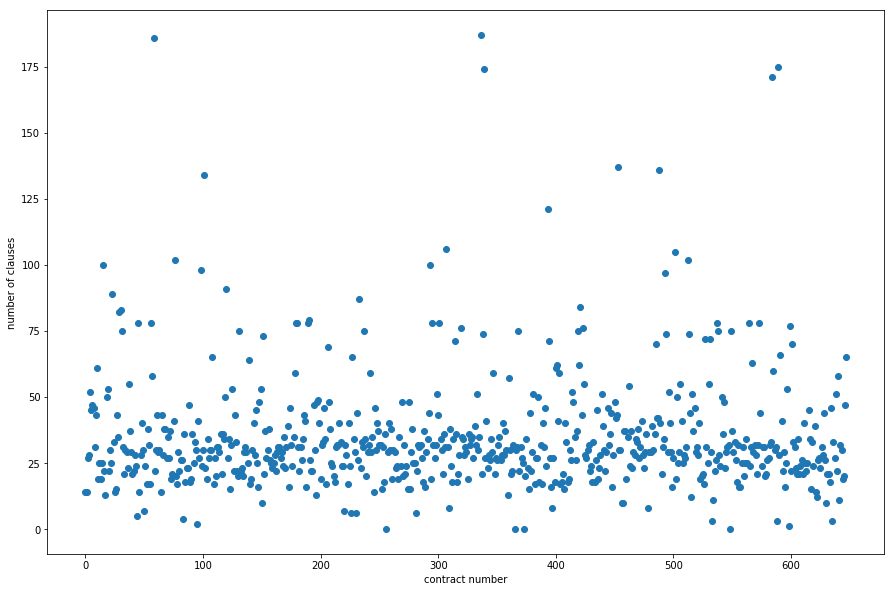

In [40]:
plt.figure(figsize=(15,10))
plt.scatter([range(contracts_df.shape[0])],contracts_df['num_clauses'])
plt.xlabel('contract number')
plt.ylabel('number of clauses')

In [41]:
contracts_df[contracts_df['num_clauses']<5]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,num_clauses
83,ARTICLE 1 FORME] La Société a été constituée s...,ARTICLE 5 La durée DUREE de la Société reste f...,ARTICLE 21 CONVENTIONS ENTRE LA SOCIETE ET SES...,ARTICLE 34 CAPITAUX PROPRES INFERIEURS A LA MO...,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,4
95,ARTICLE 2 OBJE La Société a pour objet : e La ...,ARTICLE 5 DUREE La durée de la Société est fix...,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,2
256,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
365,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
373,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
533,14.1 Pouvoirs du Président Le Président assume...,ARTICLE 15. Directeur général. L associé uniqu...,ARTICLE 16. Rémunération du président et du di...,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,3
548,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
588,ARTICLE 1 Il est formé à Paris une association...,ARTICLE 2 L association est ouverte a tout Isr...,ARTICLE 3 Le comité se réuni autant de fois qu...,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,3
598,CHAPITRE i : DEcisioNS COLLECTVES pneuen ronue...,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,1
635,ARTICLE 1 Il est formé à Paris une association...,ARTICLE 2 L association est ouverte à tout Isr...,ARTICLE 3 Le comité se réuni autant de fois qu...,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,3


We can observe that we have some outliers in the corpus (probably due to bad parsing)
after observing the json files, I deemed it fit to just drop them (badly parsed)

In [42]:
contracts_df.drop(index=[83,95,256,365,373,548,598],inplace=True)

In [43]:
contracts_df[contracts_df['num_clauses']>100]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,num_clauses
58,ARTICLE 1. FORME 3 ARTICLE 2. DENOMINATION SOC...,ARTICLE 1. 1.1 DENOMINATION OBJET SIEGE SOCIAL...,1.2 Elle fonctionne indifféremment sous la mêm...,ARTICLE 2. DÉNOMINATION SOCIALE,2.1 La dénomination sociale est : « SANTE CIE ».,2.2 Tous les actes et documents émanant de la ...,"ARTICLE 3. OBJET La Société a pour objet, dire...",ARTICLE 4. 4.1 SIEGE SOCIAL Le siège social de...,4.2 Il peut être transféré en tout autre endro...,ARTICLE 5. DUREE La durée de la Société est de...,...,1.2 Valeur vénale des titres de la Société La ...,1.3 Valeur de Marché des Actions Cédées La Val...,2.1 En cas de désaccord sur la Valeur de March...,2.2 L Expert devra déterminer la Valeur de Mar...,2.3 L Expert pourra avoir accès à tous les doc...,2.4 L Expert devra déterminer la Valeur de Mar...,2.5 La décision de l Expert liera définitiveme...,2.6 Les frais et dépenses relatifs à la déterm...,None,186
76,"ARTICLE 1 FORME La Société, de forme société p...",ARTICLE 2 DÉNOMINATION SOCIALE La dénomination...,"ARTICLE 3 OBJET La Société a pour objet, direc...",ARTICLE 4 SIÈGE SOCIAL Le siège social de la S...,ARTICLE S DURÉE La durée de la Société est de ...,"ARTICLE 6 APPORTS Lors de la constitution, les...",ARTICLE 7 CAPITAL SOCIAL Le capital social est...,ARTICLE 8 8.1 MODIFICATIONS DU CAPITAL SOCIAL ...,8.2 L associé unique ou la collectivité des as...,ARTICLE 9 9.1 Les LIBÉRATION DES ACTIONS actio...,...,None,None,None,None,None,None,None,None,None,102
101,ARTICLE 1. ARTICLE 2. ARTICLE 3. ARTICLE 4. AR...,ARTICLE 1. 1.1 DENOMINATION OBJET SIEGE SOCIAL...,1.2 Elle fonctionne indifféremment sous la mêm...,ARTICLE 2. DENOMINATION SOCIALE 2.1 La dénomin...,2.2 Tous les actes et documents émanant de la ...,"ARTICLE 3. OBJET La Société a pour objet, dire...",ARTICLE 4. SIEGE SOCIAL,4.1 Le siège social de la Société est fixé : 3...,4.2 Il peut être transféré en tout autre endro...,ARTICLE 5. DUREE La durée de la Société est de...,...,None,None,None,None,None,None,None,None,None,134
307,ARTICLE 2 DÉNOMINATION SOCIALE La dénomination...,"ARTICLE 3 OBJET La Société a pour objet, direc...",ARTICLE 4 SIÈGE SOCIAL Le siège social de la S...,ARTICLE 5 DURÉE La durée de la Société est de ...,ARTICLE 7 7.1 MODIFICATIONS DU CAPITAL SOCIAL ...,7.2 L associé unique ou la collectivité des as...,ARTICLE 8 8.1 Les LIBÉRATION DES ACTIONS actio...,8.2 Les appels de fonds sont portés à la conna...,"ARTICLE 9 FORME, CESSION ET TRANSMISSION DES A...",9.1 Les actions sont nominatives.,...,None,None,None,None,None,None,None,None,None,106
336,ARTICLE 2. DÉNOMINATION SOCIALE La dénominatio...,"ARTICLE 3. OBJET La Société a pour objet, dire...",ARTICLE 4. SIEGE SOCIAL Le siège social de la ...,"ARTICLE 5. DUREE La Société, sauf en cas de pr...",ARTICLE 7. CAPITAL SOCIAL Le capital social es...,ARTICLE 8. 8.1 MODIFICATIONS DU CAPITAL Le cap...,8.2 L associé unique ou la collectivité des as...,ARTICLE 9. LIBÉRATION DES ACTIONS,9.1 Les actions souscrites en numéraire doiven...,9.2 Les appels de fonds du surplus sont portés...,...,28.3 Pour les besoins de l article R.228 20 du...,28.4 Les Actions D rachetées seront annulées.,ARTICLE 29. CONTESTATIONS,"29.1 Toutes les contestations qui, pendant la ...","29.2 A cet effet, en cas de contestation, les ...",2.1 Détermination du Montant B1 Le Montant B1 ...,2.2 Détermination du Montant C Préalablement à...,2.3 Détermination du Montant B2 Le Montant B2 ...,1.1 Détermination du Montant Bl Le Montant B1 ...,187
339,ARTICLE 2 DÉNOMINATION SOCIALE La dénomination...,"ARTICLE 3 OBJET La Société a pour objet, direc...",ARTICLE 4 SIÈGE SOCIAL,4.1 Le siège social de la Société est fixé : 6...,4.2 Il peut être transféré en tout autre endro...,ARTICLE 5 DUREE La durée de la Société est de ...,ARTICLE 6 6.1 CAPITAL SOCIAL MODIFICATIONS DU ...,6.2 Aux terme des décisions de l associé uniqu...,6.3 Aux termes des décisions de l associé uniq...,ARTICLE 7 CAPITAL SOCIAL Le capit

In [44]:
contracts_df.loc[[58,101,589],0] = None

Text(0,0.5,'number of clauses')

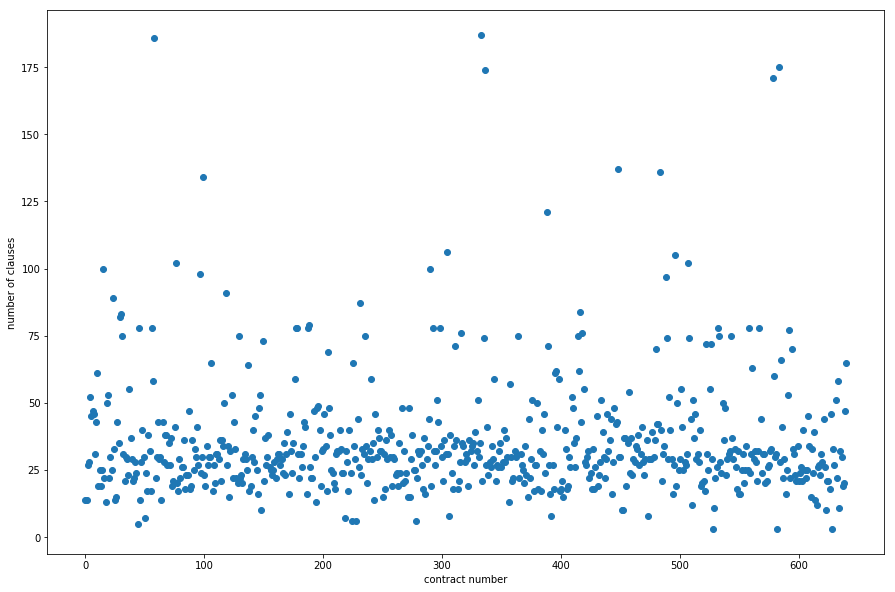

In [90]:
plt.figure(figsize=(15,10))
plt.scatter([range(contracts_df.shape[0])],contracts_df['num_clauses'])
plt.xlabel('contract number')
plt.ylabel('number of clauses')

In [94]:
contracts_df.describe() #to have an idea about the number of clusters

,num_clauses
count,641.000000
mean,35.552262
std,22.770887
min,3.000000
25%,23.000000
50%,30.000000
75%,40.000000
max,187.000000


In [45]:
clauses_df = contracts_df.drop('num_clauses',axis=1).values.flatten()
clauses_df = clauses_df[clauses_df != np.array(None)]
clauses_df = pd.DataFrame(clauses_df)
clauses_df.describe()

,0
count,22786
unique,18982
top,"ARTICLE 10 FORME, CESSION ET TRANSMISSION DES ..."
freq,31


Although the duplicates won't affect the averaging used to find the kMeans centroids (for kmeans algorithm), I still decided to remove them because I only need unique descriptions to perform the clustering. Note that dropping duplicates will still keep one of those entries in the set.

In [46]:
clauses_df.drop_duplicates(inplace=True)
clauses_df.index = range(len(clauses_df.index)) # faster than reset_index
clauses_df.describe()

,0
count,18982
unique,18982
top,ARTICLE 24 e DISSOLUTION ET LIQUIDATION Dissol...
freq,1


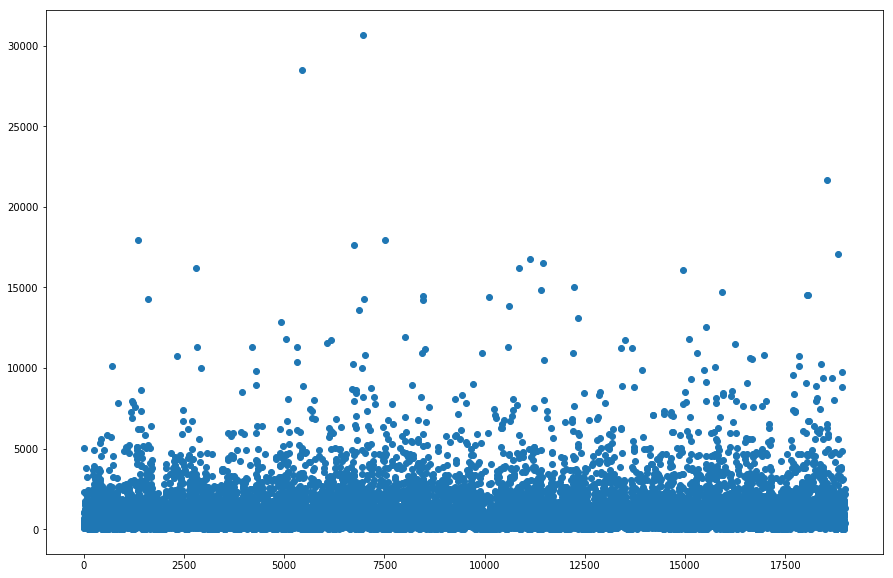

In [47]:
clauses_lengths = [len(clause[0]) for clause in clauses_df.values]
plt.figure(figsize=(15,10))
plt.scatter([range(len(clauses_lengths))], clauses_lengths)

In [48]:
mask = clauses_df[0].str.len() > 20000
clauses_df[mask]

,0
5455,ARTICLE 9 LIBERATION DES ACTIONS) Lors de la c...
6972,5.3 Droit préférentiel de souscription En cas ...
18553,"ARTICLE 11 SOUSCRIPTION, LIBERATION ET REPRESE..."


In [49]:
clauses_df.drop(clauses_df[mask].index, inplace=True)

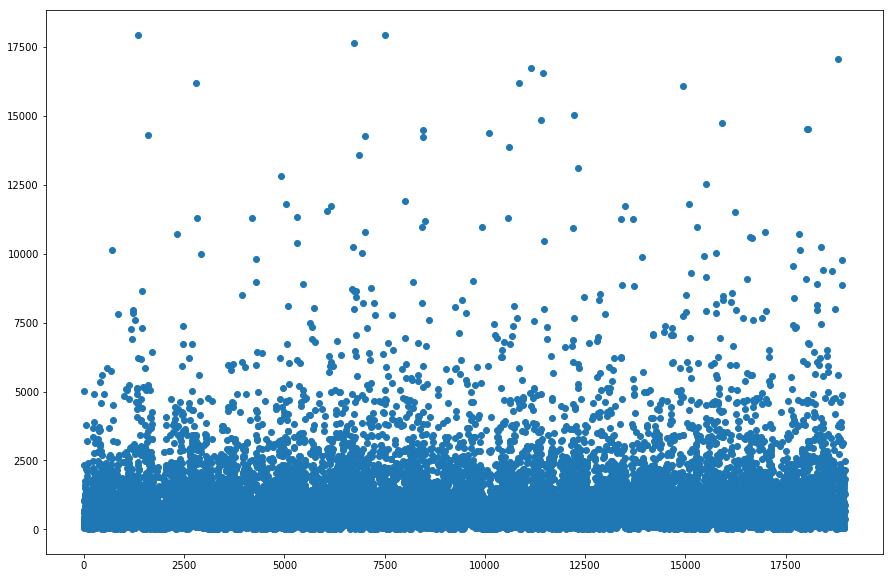

In [50]:
clauses_lengths = [len(clause[0]) for clause in clauses_df.values]
plt.figure(figsize=(15,10))
plt.scatter([range(len(clauses_lengths))], clauses_lengths)

In [51]:
test ='ARTICLE 12 SOUSCRIPTION, LIBERATION ET REPRESENTATION DES PARTS SOCIALES Les parts sociales sont souscrites en totalité par les associés.\
Elles sont intégralement libérées lorsqu elles représentent des apports en nature. Les parts représentant des apports en numéraire sont libérées d au moins un cinquième de leur montant. \
La libération du surplus intervient en une ou plusieurs fois sur décision de la gérance, dans un délai qui ne peut excéder cinq ans à compter de l immatriculation de la société au Registre \
du commerce et des sociétés. La Société peut émettre des parts sociales en rémunération d apports en industrie. Ces parts sont émises sans valeur nominale et ne sont pas prises en compte pour la \
formation du capital social. Elles sont attribuées à titre personnel et ne peuvent être cédées. En cas de décès de leur titulaire ou en cas de cessation par celui ci de ses prestations, elles sont annulées. \
Hx En cas d augmentation de capital, le capital social doit être intégralement libéré avant toute souscription de nouvelles parts sociales à libérer en numéraire, à peine de nullité de l opération. \
Les parts représentatives d apports en numéraire doivent être libérées, lors de la souscription, d un quart au moins de leur valeur nominale. La libération du surplus doit intervenir, en une ou plusieurs fois, \
dans le délai de cinq ans à compter du jour où l augmentation du capital est devenue définitive. Les parts sociales ne peuvent jamais être représentées par des titres négociables. La propriété des parts résulte\
seulement des présents statuts, des actes ultérieurs qui pourraient modifier le régulièrement réalisées. capital social et des cessions et attributions qui seraient Tout défaut de paiement des sommes dues sur \
le montant non libéré des parts sociales entraîne de plein droit et sans qu il soit besoin de procéder à une formalité quelconque, le paiement d un intérêt au taux légal à partir de la date d exigibilité, \
sans préjudice des mesures d exécution forcée prévues par la loi. En outre, lorsqu il n a pas été procédé dans le délai légal aux appels de fonds pour réaliser la libération intégrale du capital, \
tout intéressé peut demander au Président du Tribunal statuant en référé, soit d enjoindre sous astreinte à la gérance de procéder à des appels de fonds, soit de désigner un mandataire chargé de procéder \
à cette formalité. [ARTICLE 13 DROITS ET OBLIGATIONS ATTACHES AUX PARTS SOCIALES}] Chaque part sociale confére à son propriétaire un droit égal dans les bénéfices de la Société, dans la propriété de l actif \
social et dans le boni de liquidation. également droit à une voix dans tous les votes et délibérations. Elle donne Les associés ne sont tenus à l égard des tiers qu à concurrence du montant de leur apport. \
Toutefois, ils sont solidairement responsables, à l égard des tiers, pendant cing ans, de la valeur attribuée aux apports en nature lors de la constitution de la Société, lorsqu il n y a pas eu de commissaire \
aux apports ou lorsque la valeur retenue est différente de celle proposée par le Commissaire aux Apports. La propriété d une part emporte de plein droit adhésion aux statuts et aux résolutions régulièrement \
prises par les associés. [ARTICLE 14 INDIVISIBILITE DES PARTS SOCIALES] Les parts sociales sont indivisibles à l égard de la Société qui ne reconnaît qu un seul propriétaire pour chaque part. \
Les copropriétaires indivis sont tenus de désigner l un d entre eux pour les représenter auprès de la Société ; à défaut d entente, il appartient à l indivisaire le plus diligent de faire désigner par voie \
de justice un mandataire chargé conformément aux dispositions de l article 1844 du Code civil. de les représenter, Toutefois, dans tous les cas, le nu propriétaire a le droit de participer aux assemblées générales.\
pA [ARTICLE 15 1 CESSION TRANSMISSION LOCATION DES PARTS SOCIALESI Cession entre vifs. Toute cession de parts doit étre constatée par un acte notarié ou sous seings privés. Pour étre opposable à la Société, \
elle doit lui être signifiée par exploit d huissier ou être acceptée par elle dans un acte notarié. La signification peut être remplacée par le dépôt d un original de l acte de cession au siège social contre \
remise par le Gérant d une attestation de ce dépôt. Elle n est opposable aux tiers qu après accomplissement de ces formalités et, en outre, après publication des statuts modifiés au Registre du commerce et des \
sociétés ; ce dépôt peut être effectué par voie électronique. En l absence de publication des statuts modifiés au Registre du commerce et des sociétés, le cédant ou le cessionnaire peut, après mise en demeure \
du Gérant d effectuer cette publication, restée vaine au terme d un délai de huit jours, et en justifiant de la saisine du président du tribunal en application de l article L. 123 5 1 ou \
de l article L. 210 7 du Code de commerce, déposer contre récépissé l acte de cession de parts sociales au Registre du commerce et des sociétés. A titre conservatoire et jusqu à la décision du tribunal, \
ce dépôt rend la cession opposable aux tiers, sous réserve de l accomplissement des formalités prévues au deuxième alinéa du présent article. Les parts sont librement cessibles entre associés. \
Elles ne peuvent être cédées, à titre onéreux ou gratuit, à des tiers non associés et quel que soit leur degré de parenté avec le cédant, qu avec le consentement de la majorité des associés \
représentant plus de la moitié des parts sociales. Lorsque la Société comporte plus d un associé, le projet de cession est notifié à la Société et à chacun des associés par acte d huissier ou par lettre recommandée\
avec demande d avis de réception. Dans le délai de huit jours à compter de cette notification, la gérance doit convoquer l assemblée des associés pour qu elle délibère sur le projet de cession \
des parts sociales ou consulter les associés par écrit sur ledit projet. La décision de la Société, qui n a pas à être motivée, est notifiée par la gérance au cédant par lettre recommandée avec demande \
d avis de réception ou lui est remise contre émargement ou récépissé. Si la Société n a pas fait connaître sa décision dans le délai de trois mois à compter de la dernière des notifications du projet de cession, \
le consentement à la cession est réputé acquis. Si la Société a refusé de consentir à la cession, les associés sont tenus, dans le délai de trois mois à compter du refus d agrément, d acquérir ou de faire \
acquérir les parts à un prix fixé d un commun accord entre les parties ou en cas de contestation, à dire d expert dans les conditions prévues à l article 1843 4 du Code civil, les frais d expertise étant à la \
charge de la Société. A la demande du Gérant, ce délai de trois mois peut être prolongé par ordonnance du Président du Tribunal de commerce statuant sur requête, sans que cette prolongation puisse excéder six mois. \
En cas de désaccord sur le prix fixé par l Expert, le cédant peut renoncer à la cession de ses parts, dans les quinze jours de la notification dudit prix, par lettre recommandée avec demande d avis de réception. \
La Société peut également, avec le consentement de l associé cédant, décider, dans le même délai, de réduire son capital du montant de la valeur nominale des parts du cédant et de racheter les parts au prix \
déterminé dans les conditions prévues ci dessus. Un délai de paiement, qui ne saurait excéder deux ans, peut, sur justification, être accordé à la Société par le Président du Tribunal de commerce, \
statuant par ordonnance de référé. Les sommes dues portent intérêt au taux légal en matière commerciale. Si, à l expiration du délai imparti, aucune des solutions prévues n est intervenue, l associé peut réaliser \
la cession initialement prévue. Toutefois, l associé qui avait proposé de céder ses parts à une personne non associée, ne peut, en cas de non agrément, exiger le rachat de celles ci s il n en est propriétaire \
depuis deux ans au moins, sauf le cas où il les aurait recueillies par succession, liquidation de communauté entre époux ou donation du conjoint, d un ascendant ou d un descendant. 2 Revendication par \
le conjoint de la qualité d associé. La qualité d associé est reconnue au conjoint commun en biens pour la moitié des parts souscrites ou acquises au moyen de fonds communs s il notifie à la Société son \
intention d être personnellement associé. Si la notification a été effectuée lors de l apport ou de l acquisition, l agrément donné par les associés vaut pour les deux époux. Si le conjoint exerce son droit \
de revendication postérieurement à la réalisation de la souscription ou de l acquisition, il devra être agréé selon les conditions prévues ci dessus pour les cessions de parts sociales. \
L époux associé sera alors exclu du vote et ses parts ne seront pas prises en compte pour le calcul de la majorité. La décision des associés doit être notifiée au conjoint dans les deux mois de sa demande à défaut, \
l agrément est réputé acquis. En cas de refus d agrément régulièrement notifié, l époux associé le reste pour la totalité des parts de la communauté. Les notifications susvisées sont faites par lettre \
recommandée avec demande d avis de réception. 3 Transmission par décès. En cas de décès d un associé, la Société continue entre les associés survivants et les héritiers ou ayants droit de l associé décédé, \
et éventuellement son conjoint survivant. La transmission des parts sociales de l associé décédé au profit d une personne non associée est soumise à l agrément de la collectivité des associés dans les mêmes \
conditions que celles prévues au paragraphe 1 pour l agrément d un tiers non encore associé. En cas de refus d agrément, les associés survivants sont tenus de racheter ou de faire racheter par des tiers ou par \
la Société les parts des héritiers non agréés dans les conditions prévues ci dessus pour les transmissions entre vifs. Si aucune de ces solutions n intervient dans les délais impartis, l agrément \
des héritiers est réputé acquis. 10 Jix Dans les cas prévus ci dessus, la valeur des droits sociaux est déterminée au jour du décès conformément à l article 1843 4 du Code civil. Pour exercer les \
droits attachés aux parts sociales de l associé décédé, les héritiers ou ayants droit, qu ils soient ou non soumis à agrément, doivent justifier de leur état civil et de leurs qualités héréditaires \
auprès de la gérance qui peut toujours requérir de tout notaire la délivrance d expéditions ou d extraits de tous actes établissant lesdites qualités. 4. Dissolution de communauté ou de Pacs du vivant de l associé.\
En cas de liquidation de communauté légale ou conventionnelle de biens ayant existé entre un associé et son conjoint, l attribution de parts communes au conjoint qui ne possédait pas la qualité d associé est soumise \
à l agrément de la majorité des associés représentant au moins la moitié des parts sociales, dans les mêmes conditions que celles prévues pour l agrément d un tiers non associé. En cas de dissolution d un Pacs, \
la liquidation de parts indivises sera effectuée par application des dispositions des articles 515 6, alinéa 1 et 831 du Code civil, avec possibilité d attribution préférentielle des parts \
à l autre partenaire par voie de partage, à charge de soulte s il y a lieu. 5 Location des parts sociales. La location des parts sociales est interdite. [ARTICLE 16 DECES, INTERDICTION, FAILLITE D UN ASSOCIE] \
La Société n est pas dissoute par le décès, l interdiction de gérer, la liquidation judiciaire ou la faillite personnelle d un associé. [ARTICLE 17 GERANCE] La Société est administrée par un ou plusieurs Gérants, \
personnes physiques, associés ou hon, avec ou sans limitation de la durée de leur mandat. v Monsieur Alexis LE TAN Est nommé premier Gérant de la Société pour une durée illimitée. \
Sa rémunération sera fixée par la plus prochaine Assemblée. Monsieur Alexis LE TAN déclare qu aucune prescription, aucune mesure ou décision quelconque ne fait obstacle à l exercice de ce mandat. \
Les Gérants peuvent recevoir une rémunération, qui est fixée et peut être modifiée par une décision ordinaire des associés. 11 _ Tout Gérant a, par ailleurs, droit au remboursement de ses frais de déplacement\
et de représentation engagés dans l intérêt de la Société, sur présentation de toutes pièces justificatives. Dans les rapports avec les tiers, les pouvoirs du ou des Gérants sont les plus étendus \
pour agir en toute circonstance au nom de la Société, sous réserve des pouvoirs que la loi attribue expressément aux associés. La Société est engagée méme par les actes du Gérant qui ne relèvent pas de l objet social,\
à moins qu elle ne prouve que le tiers savait que l acte dépassait cet objet ou qu il ne pouvait l ignorer compte tenu des circonstances, la seule publication des statuts ne suffisant pas à constituer cette preuve. \
L opposition formée par un Gérant aux actes d un autre Gérant est sans effet à l égard des tiers, à moins qu il ne soit établi que ces derniers en ont eu connaissance. Dans les rapports entre associés, \
le Gérant ou chacun des Gérants a tous les pouvoirs nécessaires pour faire, dans l intérêt de la Société, tous actes de gestion, sauf le droit pour chacun des Gérants, s ils sont plusieurs, \
de s opposer à toute opération avant qu elle soit conclue. Le Gérant est tenu de consacrer tout le temps et les soins nécessaires aux affaires sociales. Le Gérant peut mettre \
les statuts de la Société en harmonie avec les dispositions impératives de la loi et des réglements, sous réserve de ratification par les associés statuant dans les conditions requises pour les décisions extraordinaires.\
Si la révocation est décidée sans juste motif, elle peut donner lieu à des dommages intérêts. En outre, le Gérant est révocable par le Président du Tribunal de commerce pour cause légitime, à la demande de tout associé.\
Le Gérant peut démissionner de ses fonctions à charge pour lui d informer chacun des associés au moins trois mois à l avance, par lettre recommandée avec demande d avis de réception. \
Le décès ou le retrait du Gérant n entraîne pas la dissolution de la Société. En cas de cessation des fonctions du Gérant pour quelque cause que ce soit, la mention de son nom dans les statuts \
peut être supprimée à la majorité simple des associés représentant plus de la moitié des parts sociales. Les Gérants sont responsables, individuellement ou solidairement selon les cas, \
envers la Société ou envers les tiers, soit des infractions aux dispositions législatives ou réglementaires applicables aux sociétés à responsabilité limitée, soit des violations des statuts, \
soit des fautes commises dans leur gestion. Si plusieurs Gérants ont coopéré aux mêmes faits, le tribunal détermine la part contributive de chacun d eux dans la réparation du dommage. \
Aucune décision de l Assemblée ne peut avoir pour effet d éteindre une action en responsabilité contre les Gérants pour fautes commises dans l accomplissement de leur mandat. \
12 MA [ARTICLE 18 COMMISSAIRES AUX COMPTES Un ou plusieurs Commissaires aux Comptes titulaires et suppléants peuvent ou doivent être désignés dans les conditions prévues par l article L. 223 35 du Code de commerce.\
Ils sont nommés pour une durée de six exercices et exercent leur mission dans les conditions et avec les effets prévus par les dispositions législatives et réglementaires en vigueur. \
[ARTICLE 19 CONVENTIONS ENTRE UN GERANT OU UN ASSOCIE ET LA SOCIETE] La gérance ou, s il en existe un, le Commissaire aux Comptes présente à l Assemblée ou joint aux documents communiqués aux associés\
en cas de consultation écrite, un rapport sur les conventions intervenues entre la Société et l un de ses Gérants ou associés. L Assemblée statue sur ce rapport qui doit contenir \
les mentions suivantes : e L énumération associés ; des conventions soumises à l approbation de l assemblée des e Le nom des Gérants ou associés intéressés ; « La nature et l objet desdites conventions ; \
e Les modalités essentielles de ces conventions, notamment l indication des prix ou tarifs pratiqués, des ristournes et commissions consenties, des délais de paiement accordés, des intérêts stipulés, \
des sûretés conférées et, le cas échéant, toutes autres indications permettant aux associés d apprécier l intérêt qui s attachait à la conclusion des conventions analysées ; e L importance des fournitures \
livrées ou des prestations de services fournies, ainsi que le montant des sommes versées ou reçues au cours du dernier exercice. Le Gérant ou l associé intéressé ne peut pas prendre part au vote et ses parts \
ne sont pas prises en compte pour le calcul de la majorité. Toutefois, s il n existe pas de Commissaire aux Comptes, les conventions conclues par un Gérant non associé sont soumises à l approbation préalable \
de l Assemblée. Les conventions non approuvées produisent néanmoins leurs effets, à charge pour le Gérant, et s il y a lieu, pour l associé contractant, de supporter individuellement ou solidairement, selon les cas,\
les conséquences du contrat préjudiciables à la Société. Ces dispositions s étendent aux conventions passées avec une société dont un associé indéfiniment responsable, Gérant, administrateur, directeur général, \
membre du directoire ou du conseil de surveillance, est simultanément Gérant ou associé de la Société A Responsabilité Limitée. Ces dispositions ne sont pas applicables aux conventions portant sur \
des opérations courantes et conclues à des conditions normales. A peine de nullité du contrat, il est interdit aux Gérants ou associés autres que les personnes morales de contracter sous quelque forme que ce soit,\
des emprunts auprès 13 MA de la Société, de se faire consentir par elle un découvert, en compte courant ou autrement, ainsi que de faire cautionner ou avaliser par elle leurs engagements envers les tiers. \
Cette interdiction s applique aux conjoint, ascendants et descendants des Gérants ou associés ainsi qu à toute personne interposée et aux représentants légaux des personnes morales associées.'

In [52]:
# pattern = re.compile('ARTICLE\s*d+.*ARTICLE\s*d+|' )
# re.findall(pattern,test)

In [53]:
#contracts_df.applymap(lambda x: re.findall(pattern,x) if x !=None else None)

In [54]:
# mask = clauses_df[0].str.len() >12500
# clauses_df[mask]

## Pre-processing pipeline :

before editing the data, we can extract the "labels" of each clause (for evaluation purposes)
1. **Tokenization** (nltk word tokenizer should be good)  . check out spacy as well  
2. possible way to clean data :
    * delete all numerical and alphanumerical words
    * delete "ARTICLE x.x"
    * delete punctuation
3. **lower case**
4. explore the possibility of combining some "special words" into n-grams
5. **lemmatization**
6. **stop words**
7. **Save your work**

In [55]:
clauses = clauses_df[0].values   # faster and easier than to loop on a df

In [56]:
%%time
nlp = spacy.load('fr')

Wall time: 10.6 s


In [57]:
nlp.vocab['\''].is_punct

True

In [58]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space

def ram_saver(clauses):
    for clause in clauses:
        yield clause

def lemmatized_sentence_corpus(clauses):
    """
    generator function to use spaCy to parse clauses,
    lemmatize the text, and yield sentences
    """
    
    for parsed_clause in nlp.pipe(ram_saver(clauses),
                                  batch_size=1000, n_threads=4):
        
        for sent in parsed_clause.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_space(token)])

In [59]:
intermediate_directory = os.path.join('.', 'intermediate')
unigram_sentences_filepath = os.path.join(intermediate_directory,
                                          'unigram_sentences_all.txt')

In [69]:
%%time

with codecs.open(unigram_sentences_filepath, 'w', encoding='utf_8') as f:
    for sentence in lemmatized_sentence_corpus(clauses):
        f.write(sentence + '\n')

Wall time: 1min 32s


In [60]:
unigram_sentences = LineSentence(unigram_sentences_filepath)

In [30]:
for unigram_sentence in it.islice(unigram_sentences, 230, 240):
    print( u' '.join(unigram_sentence))

article 17 remuneration du president et du directeur general les actionnaires peuvent décider de rémunérer ou non le président ou le directeur général à la majorité simple le cas échéant la rémunération peut être fixe ou proportionnelle ou à la fois fixe et proportionnelle
article 18 1 conventions entre la societe et les dirigeants comptes courants d associes les conventions qui peuvent être passées entre la société et son président et ou ses actionnaires disposant de plus de cinq pour cent 5 du capital et des droits de vote ou l un de ses dirigeants sont soumises
aux formalités de contrôle prescrites par la loi les conventions non approuvées produisent néanmoins leurs effets à charge pour la personne intéressée et éventuellement pour le président et les autres dirigeants d en
supporter les conséquences dommageables pour la société ces dispositions ne sont pas applicables aux conventions portant sur les opérations courantes et conclues a des conditions normales les interdictions prévue

In [61]:
bigram_model_filepath = os.path.join(intermediate_directory, 'bigram_model_all')

In [62]:
%%time
# bigram_model = Phraser(Phrases(unigram_sentences));

# bigram_model.save(bigram_model_filepath)
#load the finished model from disk
bigram_model = Phraser.load(bigram_model_filepath)

Wall time: 14 ms


In [63]:
bigram_sentences_filepath = os.path.join(intermediate_directory,
                                         'bigram_sentences_all.txt')

In [53]:
%%time
with codecs.open(bigram_sentences_filepath, 'w', encoding='utf_8') as f:

    for unigram_sentence in unigram_sentences:

        bigram_sentence = u' '.join(bigram_model[unigram_sentence])

        f.write(bigram_sentence + '\n')

Wall time: 9.26 s


In [65]:
bigram_sentences = LineSentence(bigram_sentences_filepath)

In [66]:
trigram_model_filepath = os.path.join(intermediate_directory,
                                      'trigram_model_all')

In [67]:
%%time

# trigram_model = Phraser(Phrases(bigram_sentences))

# trigram_model.save(trigram_model_filepath)

#load the finished model from disk
trigram_model = Phraser.load(trigram_model_filepath)

Wall time: 40.9 ms


In [68]:
trigram_sentences_filepath = os.path.join(intermediate_directory,
                                          'trigram_sentences_all.txt')

In [58]:
%%time
with codecs.open(trigram_sentences_filepath, 'w', encoding='utf_8') as f:

    for bigram_sentence in bigram_sentences:

        trigram_sentence = u' '.join(trigram_model[bigram_sentence])

        f.write(trigram_sentence + '\n')

Wall time: 8.79 s


In [69]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

In [70]:
for trigram_sentence in it.islice(trigram_sentences, 230, 240):
    print (u' '.join(trigram_sentence))
    print (u'')

article 17_remuneration du president et du directeur_general les actionnaires peuvent décider de rémunérer ou non le président ou le directeur_général à la majorité_simple le cas_échéant la rémunération peut être fixe ou proportionnelle ou à la fois_fixe et proportionnelle

article 18 1 conventions_entre la societe et les dirigeants comptes_courants d associes les conventions qui peuvent être passées_entre la société et son président et ou ses actionnaires disposant de plus de cinq pour cent_5 du capital et des droits de vote ou l un de ses_dirigeants sont_soumises

aux formalités de contrôle_prescrites par la loi les conventions_non_approuvées produisent_néanmoins_leurs_effets à charge pour la personne_intéressée et éventuellement pour le président et les autres_dirigeants d en

supporter les conséquences_dommageables_pour la société ces dispositions ne sont pas_applicables aux_conventions_portant sur les opérations_courantes et conclues a des conditions_normales les interdictions_pré

In [71]:
trigram_clauses_filepath = os.path.join(intermediate_directory,
                                        'trigram_transformed_clauses_all.txt')

In [62]:
%%time

with codecs.open(trigram_clauses_filepath, 'w', encoding='utf_8') as f:

    for parsed_clause in nlp.pipe(ram_saver(clauses),
                                  batch_size=10000, n_threads=4):

        # lemmatize the text, removing punctuation and whitespace
        unigram_clause = [token.lemma_ for token in parsed_clause
                          if not punct_space(token)]

        # apply the first-order and second-order phrase models
        bigram_clause = bigram_model[unigram_clause]
        trigram_clause = trigram_model[bigram_clause]

        # remove any remaining stopwords
        trigram_clause = [term for term in trigram_clause
                          if term not in spacy.fr.STOP_WORDS]

        # write the transformed clause as a line in the new file
        trigram_clause = u' '.join(trigram_clause)
        f.write(trigram_clause + '\n')

Wall time: 1min 42s


In [72]:
print( u'Original:' + u'\n')

for clause in it.islice(clauses, 11, 12):
    print (clause)

print (u'----' + u'\n')
print (u'Transformed:' + u'\n')

with codecs.open(trigram_clauses_filepath, encoding='utf_8') as f:
    for clause in it.islice(f, 11, 12):
        print (clause)

Original:

ARTICLE 13 1 Droits des associés ou de l associé unique Droits attribués aux parts Chaque part donne droit à une fraction des bénéfices et de l actif social proportionnellement au nombre de parts existantes. 2 Transmission des droits Les droits et obligations attachés aux parts les suivent dans quelque main qu elles passent. La propriété d une part emporte de plein droit adhésion aux statuts et aux résolutions réguliérement prises par les associés. Les représentants, peuvent, sous ayants quelque droit, prétexte conjoint que ce et soit, héritiers requérir d un associé l apposition ne des scellés sur les biens et valeurs de la société, ni en demander le partage ou la licitation. 3 Nantissement des parts Si la société a donné son consentement à un projet de nantissement de parts sociales, ce consentement emportera l agrément du cessionnaire en cas de réalisation forcée des parts nanties, selon ces conditions de l article 2078 du Code civil, à moins que la société ne préfère, ap

In [73]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import warnings
import pickle

In [74]:
trigram_dictionary_filepath = os.path.join(intermediate_directory,
                                           'trigram_dict_all.dict')

In [76]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to learn the dictionary yourself.
if 1 == 1:

    trigram_clauses = LineSentence(trigram_clauses_filepath)

    # learn the dictionary by iterating over all of the reviews
    trigram_dictionary = Dictionary(trigram_clauses)
    
    # filter tokens that are very rare or too common from
    # the dictionary (filter_extremes) and reassign integer ids (compactify)
    trigram_dictionary.filter_extremes(no_below=10, no_above=0.4)
    trigram_dictionary.compactify()

    trigram_dictionary.save(trigram_dictionary_filepath)
    
# load the finished dictionary from disk
trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)

Wall time: 1.75 s


In [79]:
trigram_bow_filepath = os.path.join(intermediate_directory,
                                    'trigram_bow_corpus_all.mm')

In [80]:
def trigram_bow_generator(filepath):
    """
    generator function to read clauses from a file
    and yield a bag-of-words representation
    """
    
    for clause in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(clause)

In [81]:

%%time

# this is a bit time consuming - make the if statement True
# if you want to build the bag-of-words corpus yourself.
if 1 == 1:

    # generate bag-of-words representations for
    # all reviews and save them as a matrix
    MmCorpus.serialize(trigram_bow_filepath,
                       trigram_bow_generator(trigram_clauses_filepath))
    
# load the finished bag-of-words corpus from disk
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)

Wall time: 2.45 s


In [82]:
lda_model_filepath = os.path.join(intermediate_directory, 'lda_model_all')

In [95]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to train the LDA model yourself.
if 1 == 1:

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # workers => sets the parallelism, and should be
        # set to your number of physical cores minus one
        lda = LdaMulticore(trigram_bow_corpus,
                           num_topics=40,
                           id2word=trigram_dictionary)
    
    lda.save(lda_model_filepath)
    
# load the finished LDA model from disk
lda = LdaMulticore.load(lda_model_filepath)

Wall time: 7.83 s


In [98]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print (u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print (u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [103]:
explore_topic(topic_number=39)

term                 frequency

actions              0.019
président            0.018
cas                  0.015
associé              0.011
décision             0.010
cession              0.008
délai                0.008
exercice             0.007
agrément             0.006
compter              0.006
directeur_général    0.006
commerce             0.005
exclusion            0.005
cédant               0.005
droit                0.005
date                 0.004
tiers                0.004
collectivité         0.004
social               0.004
parts                0.004
assemblée            0.004
gérant               0.004
réception            0.004
décisions            0.004
commissaire_aux_comptes 0.004


In [104]:
LDAvis_data_filepath = os.path.join(intermediate_directory, 'ldavis_prepared')

In [108]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if 1 == 1:

    LDAvis_prepared = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus,
                                              trigram_dictionary)

    with open(LDAvis_data_filepath, 'wb',encoding="utf8") as f: #open in binary mode for
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)

ValueError: binary mode doesn't take an encoding argument

In [109]:
pyLDAvis.display(LDAvis_prepared)

## Feature engineering

* **TF-IDF** or **TF** depending on the "clustering" model (NMF , LDA, Kmeans, LSI ...)
* if possible find some legal words embeddings for later semantic analysis

## Modeling
* LDA
* NMF
* Kmeans

## Evaluation and qualitative analysis
* look for possible measures and scores (coherence measure)

## Semantic analysis to extraction variation inside a cluster
* use Word embeddings

The problem here is how to measure similarity between documents (clause). one way to do this is to average the word embeddings forming the document into one single vector (**doc embedding**). 

the similarity measure would probably be the **cosine distance**